In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from potentials.MullerBrown import MullerBrown
from simulations.UnbiasedMD import OverdampedLangevin

In [3]:
from eigenfunctions.neural_net_models import EigenFunctions
from eigenfunctions.train_eigenfuncs import TrainEigenFunctions

In [4]:
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 345
set_all_seeds(seed)

Using device: cuda


In [5]:
pot = MullerBrown()
## Define the radius of the R and P sets
R_radius = 0.1
P_radius = 0.1
pot.set_R_radius(R_radius)
pot.set_P_radius(P_radius)
## Generate 100 penalization points on each boundary of R and P
theta = np.random.uniform(0,np.pi, size=[100])
pen_points = np.append(np.append(pot.minR + np.array([R_radius * np.cos(theta), R_radius * np.sin(theta)]).T, np.zeros([100, 1]), axis=1), np.append(pot.minP + np.array([P_radius * np.cos(theta), P_radius * np.sin(theta)]).T, np.ones([100, 1]), axis=1), axis=0)
## Re parameterise the MEP from the various steepest descent paths
MEP = [pot.minimum_energy_paths[0][0]]
i = 1
while i < len(pot.minimum_energy_paths[0]):
    if np.sqrt(np.sum((MEP[-1] - pot.minimum_energy_paths[0][i])**2)) > pot.dx:
        MEP.append(pot.minimum_energy_paths[0][i])
    i += 1
i = 1
while i < len(pot.minimum_energy_paths[1]):
    if np.sqrt(np.sum((MEP[-1] - pot.minimum_energy_paths[1][-i])**2)) > pot.dx:
        MEP.append(pot.minimum_energy_paths[1][-i])
    i += 1
MEP = np.array(MEP)

In [6]:
beta = 0.05
dt = 0.0001
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 2* 10**5

In [7]:
set_all_seeds(seed)
traj_dict = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=True)

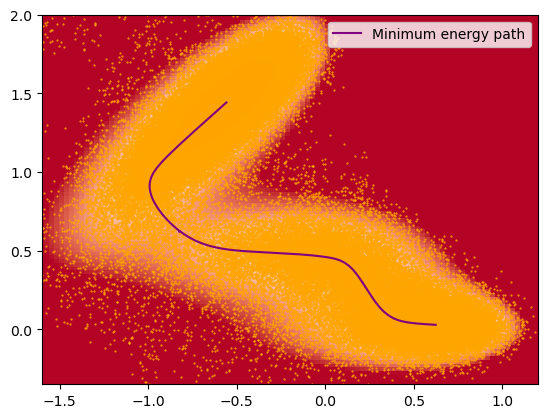

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax.scatter(traj_dict["x_traj"][:, 0], traj_dict["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.legend()

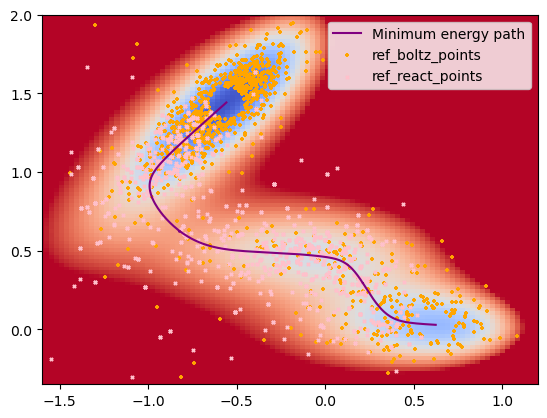

In [9]:
react_points = np.loadtxt('react_trajs_mullerbrown.txt')

ref_react_points = []
ref_boltz_points = [] 
for i in range(1000):
    index = np.random.choice(len(traj_dict["x_traj"]))
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        index = np.random.choice(len(traj_dict["x_traj"]))
    ref_boltz_points.append(traj_dict["x_traj"][index])
    index = np.random.choice(len(react_points))
    while pot.in_P(react_points[index]) or pot.in_R(react_points[index]):
        index = np.random.choice(len(react_points))
    ref_react_points.append(react_points[index])
ref_react_points = np.array(ref_react_points)
ref_boltz_points = np.array(ref_boltz_points)

fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
ax.scatter(ref_boltz_points[:, 0], ref_boltz_points[:, 1], marker="+", color="orange", s=5, label="ref_boltz_points")
ax.scatter(ref_react_points[:, 0], ref_react_points[:, 1], marker="x", color="pink", s=5, label="ref_react_points")
ax.legend()

In [10]:
set_all_seeds(0)

K = 8 * 10**2 # number of short trajectories 
N = 100 # time lagg in number of delta t
max_epochs = 10000

boudary_weight = 1.0 * 10**0
dataset = {"single_trajs_pos": [], 
           "single_trajs_gauss": [], 
           "single_trajs_weights": [], 
           "multiple_trajs_pos": [], 
           "multiple_trajs_gauss": [], 
           "multiple_trajs_weights": [],
           'dt': dt, 'beta': beta}

for k in range(2 * K):
    x_traj = []
    gauss_traj = []
    second_trajs_pos = []
    second_trajs_gauss = []
    index = np.random.choice(n_steps - N)
    while pot.in_P(traj_dict["x_traj"][index]) or pot.in_R(traj_dict["x_traj"][index]):
        index = np.random.choice(n_steps - N)
    x_traj.append(traj_dict["x_traj"][index:index+1])
    second_trajs_pos.append(traj_dict["x_traj"][index:index+1])
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(x_traj[-1], 1, save_grad=False, save_gauss=True)
            x_traj.append(short_traj["x_traj"][0:1]) 
            gauss_traj.append(short_traj["gauss_traj"][0:1])
        else:
            x_traj.append(x_end)
            gauss_traj.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    end_in_R_or_P = False
    for i in range(N):
        if not end_in_R_or_P:
            short_traj = unbiased_OL_on_MB.run(second_trajs_pos[-1], 1, save_grad=False, save_gauss=True)
            second_trajs_pos.append(short_traj["x_traj"][0:1]) 
            second_trajs_gauss.append(short_traj["gauss_traj"][0:1])
        else:
            second_trajs_pos.append(x_end)
            second_trajs_gauss.append(np.zeros_like(x_end))
        if pot.in_P(short_traj["x_traj"][0]) or pot.in_R(short_traj["x_traj"][0]):
            end_in_R_or_P = True
            x_end = short_traj["x_traj"][0:1]
    dataset["single_trajs_pos"].append(x_traj)
    dataset["single_trajs_gauss"].append(gauss_traj)
    dataset["multiple_trajs_pos"].append([x_traj, second_trajs_pos])
    dataset["multiple_trajs_gauss"].append([gauss_traj, second_trajs_gauss])
    if end_in_R_or_P:
        dataset["single_trajs_weights"].append([boudary_weight])
        dataset["multiple_trajs_weights"].append([boudary_weight])
    else:
        dataset["single_trajs_weights"].append([1.])
        dataset["multiple_trajs_weights"].append([1.])
dataset["single_trajs_weights"] = np.array(dataset["single_trajs_weights"])
dataset["multiple_trajs_weights"] = np.array(dataset["multiple_trajs_weights"])
dataset["single_trajs_gauss"] = np.array(dataset["single_trajs_gauss"])[:, :, 0, :]
dataset["single_trajs_pos"] = np.array(dataset["single_trajs_pos"])[:, :, 0, :]
dataset["multiple_trajs_pos"] = np.array(dataset["multiple_trajs_pos"])[:, :, :, 0, :]
dataset["multiple_trajs_gauss"] = np.array(dataset["multiple_trajs_gauss"])[:, :, :, 0, :]
dataset["boltz_weights"] =  dataset["single_trajs_weights"] 
dataset["boltz_pos"] = dataset["single_trajs_pos"][:, 0, :]
dataset["boltz_pos_lagged"] = dataset["single_trajs_pos"][:, -1, :]

In [11]:
seed = 1000
set_all_seeds(seed)
ef = EigenFunctions([2, 20, 20, 1], 0)

In [12]:
# Set the loss function parameters 
loss_params = {}
dset = {}
dset["dt"] = dataset["dt"]
dset["beta"] = dataset["beta"]
loss_params["ito_loss_weight"] = 1.0
loss_params["grad_weight"] = 0.
loss_params["normalisation_weight"] = 1.0 * 10**0
dset["single_trajs_weights"] = dataset["single_trajs_weights"]
dset["single_trajs_gauss"] = dataset["single_trajs_gauss"]
dset["single_trajs_pos"] = dataset["single_trajs_pos"]

loss_params["n_wait"] = 50
# Create training object 
ef_train = TrainEigenFunctions(ef, pot, dset, n_func=1)
# Do train test splitt of the dataset 
ef_train.train_test_split(train_size=K)
ef_train.split_training_dataset_K_folds(2)
ef_train.set_train_val_data(0)
# Set the optimizer 
ef_train.set_optimizer('Adam', 0.001)

ef_train.set_loss_weight(loss_params)
# Set the batch size and a max number of epochs 
batch_size = 10**3
max_epochs = 3


boltz_traj_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
boltz_traj_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_1 value not provided, set to default value of:  0.0
multiple_trajs_fixed_point_loss_weight_2 value not provided, set to default value of:  0.0
squared_grad_boltz_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


In [13]:
print(ef_train.grad_weight)

0.0


In [14]:
loss_dict = ef_train.train(batch_size, max_epochs)

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [ ]:
ef_train.ef_model.to('cuda')
ef_on_grid = ef_train.ef_model.xi(pot.x2d)
ef_1_on_grid = ef_on_grid[:, 0].reshape([100, 100])
#ef_2_on_grid = ef_on_grid[:, 1].reshape([100, 100])
#ef_3_on_grid = ef_on_grid[:, 2].reshape([100, 100])

ef_on_grid

In [ ]:

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][:], label='train loss')
ax0.plot(loss_dict["test_loss"][:], label='test loss')
ax0.legend()
# first eigenfunc
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ef_1_on_grid, 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("1st EF iso-levels")
# first eigenfunc
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ef_1_on_grid, 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("1st EF iso-levels")
# first eigenfunc
pot.plot_potential_heat_map(ax1)
ax1.plot(MEP[:, 0], MEP[:, 1], color='purple', label='Minimum energy path')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, ef_1_on_grid, 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("1st EF iso-levels")